<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 4 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

dataiter = iter(test_loader)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Linear(28 * 28, 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32),  nn.ReLU(), # 32>10 to account for variation of members within the same class
        )
          
        self.decoder = torch.nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 512), nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.ReLU(),
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        return x
        
    def decode(self, x):
        x = self.decoder(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)


In [3]:

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

epochs = 10
outputs = []
losses = []
model.train()
for epoch in range(epochs):
    for (image, _) in train_loader:
        image = image.to(device).reshape(-1, 28*28)
        reconstructed = model(image)
        loss = loss_function(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu())
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    print("loss: ",sum(losses[-batch_size:]).item()/batch_size)
    outputs.append((epochs, image, reconstructed))
  

loss:  0.03646139055490494
loss:  0.03315090015530586
loss:  0.024173013865947723
loss:  0.02398032322525978
loss:  0.018275421112775803
loss:  0.021417194977402687
loss:  0.0182761512696743
loss:  0.018528195098042488
loss:  0.017887357622385025
loss:  0.018125321716070175


original:


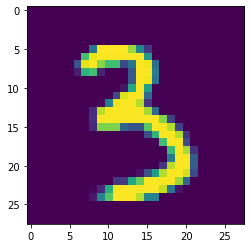

encoded:  tensor([0.0000, 0.0000, 2.7276, 8.6770, 2.4561, 0.4756, 0.0000, 2.5460, 1.4331,
        2.5319, 0.0000, 0.0000, 3.4512, 2.5926, 2.3621, 0.8261, 1.2919, 0.0000,
        0.8955, 0.0000, 0.9224, 2.0101, 0.0000, 0.0000, 0.7448, 0.0000, 4.3835,
        4.0412, 2.1932, 4.6301, 1.8076, 0.0000], device='cuda:0',
       grad_fn=<ReluBackward0>)
reconstructed:


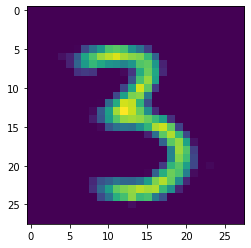

In [12]:
# evaluate

item, labels = dataiter.next() # images, labels
item = item.reshape(-1, 28, 28)
print("original:")
plt.imshow(item.cpu()[0])
plt.show()

model.eval()
# reconstructed = model(item[0].flatten().to(device))
encoded = model.encode(item[0].flatten().to(device))
print("encoded: ",encoded)
reconstructed = model.decode(encoded)

print("reconstructed:")
reconstructed = reconstructed.reshape(-1, 28, 28)
plt.imshow(reconstructed.detach().cpu()[0])
plt.show()
